In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from sklearn.utils import resample
from sklearn.preprocessing import MultiLabelBinarizer
#import seaborn as sns
from cuml.neighbors import KNeighborsClassifier  # Importing MLKNN from RAPIDS
from cuml.decomposition import PCA
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
from keras.layers import StringLookup
warnings.filterwarnings("ignore")

2024-11-05 07:53:37.343838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 07:53:37.377153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 07:53:37.435312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 07:53:37.461823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 07:53:37.501641: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load embeddings and codes
embeddings1 = np.load("embeddings_1.npy")
embeddings2 = np.load("embeddings_2.npy")

with open("icd_codes_1.txt", 'r') as file:
    codes1 = [line.strip('\n').split(';') for line in file.readlines()]
with open("icd_codes_2.txt", 'r') as file:
    codes2 = [line.strip('\n').split(';') for line in file.readlines()]

In [3]:
Code1 = pd.Series([label for sublist in codes1 for label in sublist ])
Code2 = pd.Series([label for sublist in codes2 for label in sublist ])

In [4]:
print("No of Unique codes in ICD_Codes_1:",len(Code1.unique()))
print("No of Unique codes in ICD_Codes_2:",len(Code2.unique()))

No of Unique codes in ICD_Codes_1: 1373
No of Unique codes in ICD_Codes_2: 1294


In [5]:
# Concatinating both the codes
CODE = pd.concat([Code1, Code2])
print("No of Unique ICD10 Codes:",len(CODE.unique()))

No of Unique ICD10 Codes: 1400


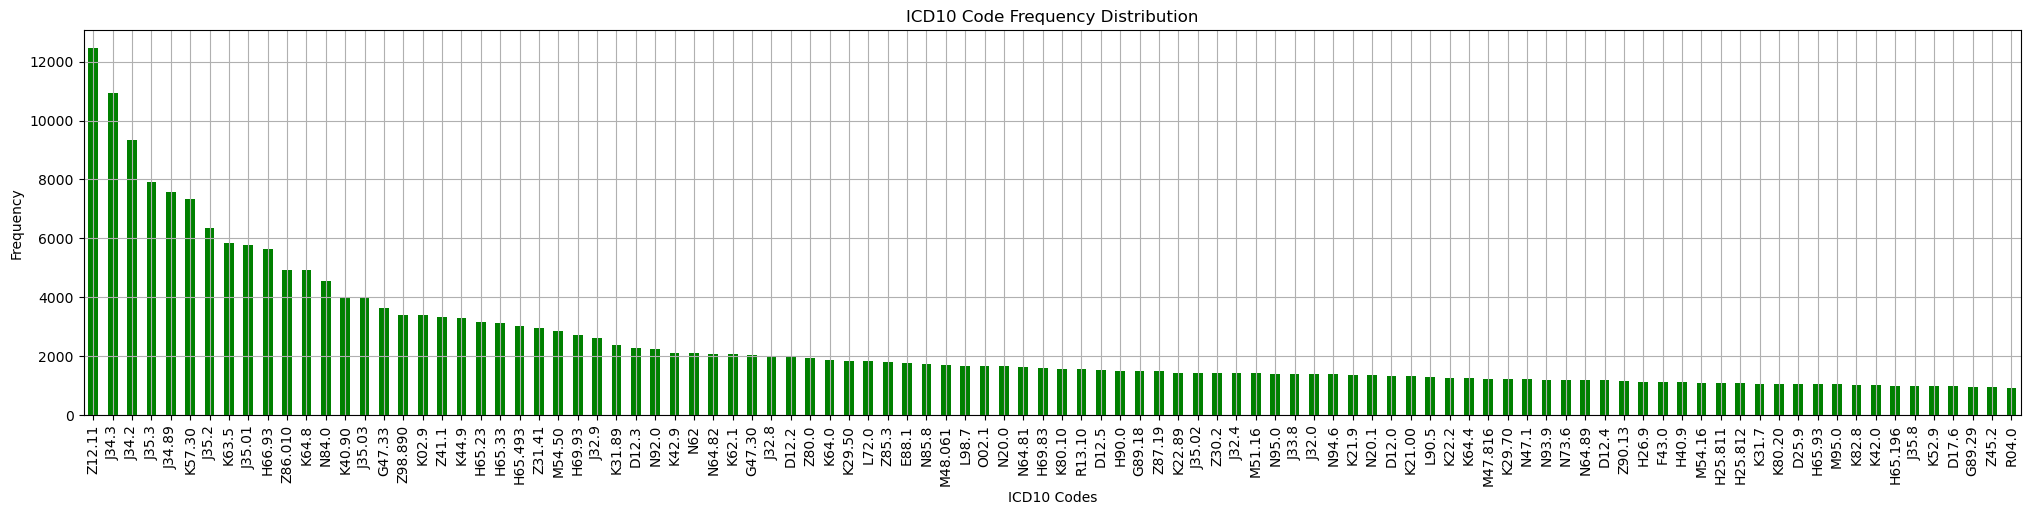

In [6]:
CODE.value_counts()[:100].plot(kind = 'bar', figsize= (25,5), color='green')
plt.title('ICD10 Code Frequency Distribution') # Top 100 ICD10 codes which is frequently repeated as labels to embeddings
plt.xlabel('ICD10 Codes')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [7]:
threshold = 100
underrepresented_class = CODE.value_counts()[CODE.value_counts() < threshold].index

In [8]:
# Extract samples (indices) that contain underrepresented codes
samples_to_oversample = [i for i, code_list in enumerate(codes1) if any(code in underrepresented_class for code in code_list)]
len(samples_to_oversample)

15816

In [9]:
X_resampled, Y_resampled = resample(embeddings1[samples_to_oversample], [codes1[i] for i in samples_to_oversample], replace=True, n_samples=27000)

In [10]:
codes1.extend(Y_resampled)

In [11]:
# Concatenate original and oversampled data
Embeddings1 = np.vstack((embeddings1, X_resampled))
Codes1 = codes1

In [12]:
X_resampled1, Y_resampled1 = resample(embeddings2[samples_to_oversample], [codes2[i] for i in samples_to_oversample], replace=True, n_samples=27000)

In [13]:
codes2.extend(Y_resampled1)

In [14]:
# Concatenate original and oversampled data
Embeddings2 = np.vstack((embeddings2, X_resampled1))
Codes2 = codes2

In [15]:
len(Embeddings1), len(Embeddings2), len(Codes1), len(Codes2)

(126491, 126491, 126491, 126491)

In [16]:
vocab = list(CODE.unique())

In [17]:
# Create the StringLookup layer with multi_hot output mode
lookup = StringLookup(vocabulary=vocab, output_mode='multi_hot')

I0000 00:00:1730773420.423799    3850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730773420.424438    3850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730773420.424460    3850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730773420.428765    3850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730773420.428789    3850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [18]:
import copy
C = copy.deepcopy(Codes1)

In [19]:
C.extend(Codes2) # contains codes1 followed by codes2 labels

In [20]:
len(C), len(codes2)+len(codes1) # to show both are of same length

(252982, 252982)

In [21]:
Embeddings = np.vstack((Embeddings1, Embeddings2))

In [22]:
len(Embeddings), Embeddings.shape

(252982, (252982, 1024))

In [23]:
p = PCA(n_components=500).fit(Embeddings)

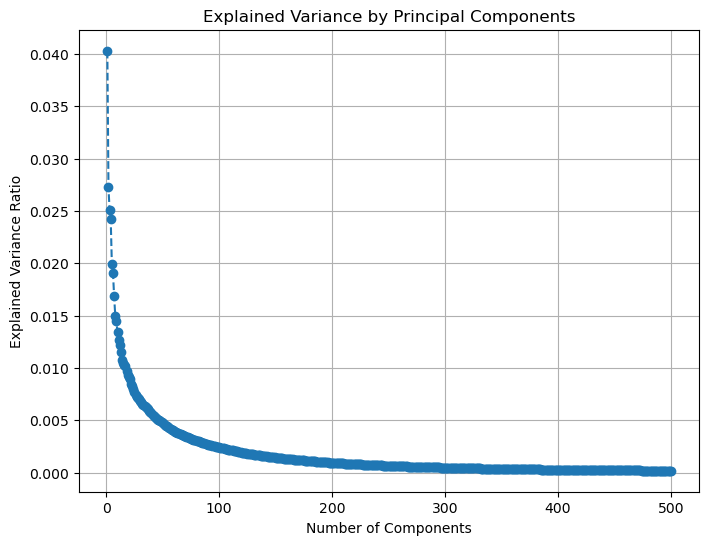

In [24]:
explained_variance = p.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()



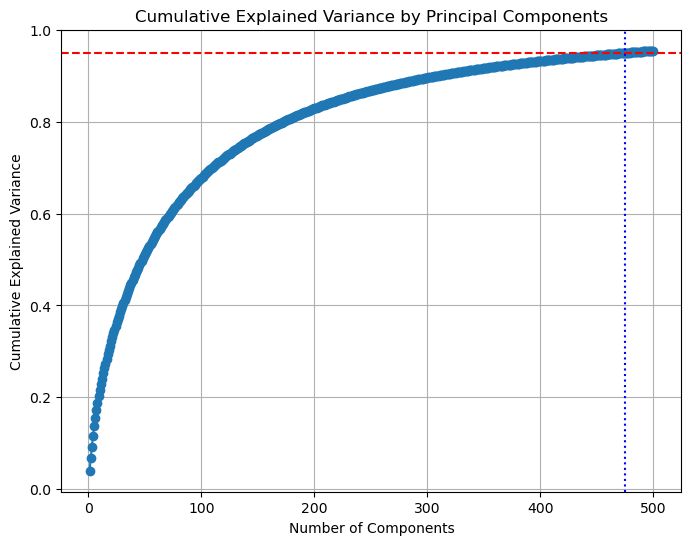

In [25]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x = 475, color = 'b', linestyle='dotted')
plt.grid()
plt.show()

In [26]:
Embeddings_transformed = PCA(n_components=500).fit_transform(Embeddings)


In [27]:
max_length = max(len(sublist) for sublist in C)
Codes_padded = pad_sequences(C, maxlen=max_length, padding='post', value='', dtype=object)

In [28]:
output = lookup(Codes_padded)

W0000 00:00:1730773430.271894    4024 gpu_backend_lib.cc:593] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /home/conda/feedstock_root/build_artifacts/tensorflow-split_1729076995378/_build_env/targets/x86_64-linux
  /usr/local/cuda
  /home/student/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/student/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


In [29]:
output.numpy().shape, Embeddings_transformed.shape

((252982, 1401), (252982, 500))

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(Embeddings_transformed, output.numpy(), test_size=0.2, random_state=42)

In [31]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [32]:
from cuml.multiclass import OneVsRestClassifier
from cuml.linear_model import LogisticRegression

In [33]:
#K = KNeighborsClassifier(weights='uniform', n_neighbors=5)
L = LogisticRegression(C=0.1, max_iter=10000)
K = OneVsRestClassifier(L)

In [34]:
K

OneVsRestClassifier()

In [35]:
K.fit(Embeddings_transformed, output.numpy())

from sklearn.metrics import f1_score
Y_pred_test = K.predict(X_test)
f1_macro = f1_score(Y_test, Y_pred_test, average='macro', zero_division=0)

print(f"F1 Macro Score for test data: {f1_macro}")

[W] [07:54:17.741855] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:20.120040] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:20.851915] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:26.581283] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:27.349604] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:30.753665] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:33.415261] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:34.180070] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:36.416806] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:54:37.586140] L-BFGS stopped, because the line search fa

In [36]:
print("Training!!!")

Training!!!


In [37]:
embeddings_test = np.load("test_data.npy")
pca = PCA(n_components=500).fit(Embeddings)  # Fit PCA on training data
Embeddings_test_transformed = pca.transform(embeddings_test)  # Apply same transformation to test data


Test_pred = K.predict(Embeddings_test_transformed)


In [38]:
V = lookup.get_vocabulary()
def codes_prediction(pred):
    return [V[i] for i in np.where(pred == 1)[0]]

In [39]:

Test_decode = [codes_prediction(i) for i in Test_pred]

with open('decoded_labels_500.txt', 'w') as file:
    for sublist in Test_decode:
        file.write(','.join(sublist) + '\n')

In [40]:
def clean_predictions(pred):
    if all(code == '[UNK]' for code in pred):
        return ''
    code_pred = [code for code in pred if code!='[UNK]']
    code_pred.sort()
    return ';'.join(code_pred)

In [41]:
Test_decode_cleaned = [clean_predictions(i) for i in Test_decode]

In [42]:
sub = pd.DataFrame({'id': range(1, len(Test_decode_cleaned)+1),
                   'labels': Test_decode_cleaned})

In [43]:
sub.to_csv('submission15.csv', index=False)

In [44]:
print("Done!")

Done!
